# Predicting the exposure time needed to obtain a desired signal to noise ratio with <tt>astroplan</tt>

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
    <li>Use <tt>astroquery.Gaia</tt> and <tt>astroplan.FixedTarget</tt> to obtain information about the target</li>
    <li>Obtain a model spectrum by querying from PHOENIX</li>
    <li>Set the location of the observer with <tt>astroplan.observer</tt></li>
    <li>Set up the telescope model with <tt>astroplan.telescope</tt></li>
    <li>Calculate the exposure time with <tt>astroplan</tt>'s <tt>exptime.exptime_from_ccd_snr</tt></li>
    <li>Add atmospheric transmission with <tt>astroplan.skymodel</tt></li>
</ul>

## Keywords
astroplan, synphot, synthetic photometry, astropy, astroquery, astronomy

## Summary
<a href="https://astroplan.readthedocs.io/en/latest/" target="_blank"><tt>astroplan</tt></a> is an astropy-affiliated package for helping astronomers plan and schedule observations. In this tutorial we will show how to predict the exposure time needed to obtain a given signal to noise ratio for a target star. Specifically, we will:
<ol>
<li><a href="#query_properties">Query the properties of a target star</a></li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#observer">Set the location of the observer</a></li>
<li><a href="#telescope">Set up the telescope model</a></li>
<li><a href="#exptime">Calculate the exposure time</a></li>
<li><a href="#skymodel">(optional) Add an atmospheric transmission model</a></li>
</ol>

In [25]:
%matplotlib inline

import astropy.units as u

import warnings
import numpy as np
import matplotlib.pyplot as plt

# warnings.filterwarnings("ignore", module='astropy.io.votable.tree')
warnings.simplefilter("ignore")

<a id='query_properties'></a>
## 1. Query the properties of a target star

In this example we will use HAT-P-11 as the target. We will model the spectrum of HAT-P-11 with a PHOENIX stellar atmosphere model, which we can obtain by specifying a stellar temperature and querying from the Gottingen Spectral Library.

To get the stellar temperature, we can use <tt>FixedTarget.from_name</tt> to get the coordinates of HAT-P-11, then give these coordinates to <tt>astroquery</tt>'s Gaia query:

In [26]:
from astroplan import FixedTarget
from astroquery.gaia import Gaia

hatp11 = FixedTarget.from_name('Hat-p-11')

# width / height of search:
width = u.Quantity(1, u.arcmin)
height = u.Quantity(1, u.arcmin)
search_results = Gaia.query_object_async(coordinate=hatp11.coord, width=width, height=height)

# the queried star should be the one nearest to the given coordinates
search_results.add_index('dist', unique=True)
hatp11_info = search_results.loc['dist', min(search_results['dist'])]

T_eff = round(hatp11_info['teff_val'], -2)  # round to nearest 100 K

Query finished.


Since the spectrum is defined at the source, we have to scale for the distance to the target to get the flux at the telescope:

In [27]:
stellar_radius = hatp11_info['radius_val'] * u.R_sun
parallax = hatp11_info['parallax'] * u.mas
# parallax is given by Gaia in milliarcseconds, so convert to parsec:
distance = parallax.to(u.parsec, equivalencies=u.parallax())

distance_scale = float(stellar_radius / distance) ** 2 / np.pi

<a id="phoenix"></a>
## 2. Obtain a model spectrum from PHOENIX

Now use <tt>astropy.io.fits.getdata</tt> to query from PHOENIX to get the spectrum:

In [28]:
from astropy.io import fits

flux_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=int(T_eff), log_g=4.5)
wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')

flux_of_target = fits.getdata(flux_url) * distance_scale
waveset_of_target = fits.getdata(wavelength_url)

It is good practice (and for some packages, essential) to attach units to quantities so that you can be sure the final results are scaled correctly. The units we use here are specified by the PHOENIX models.

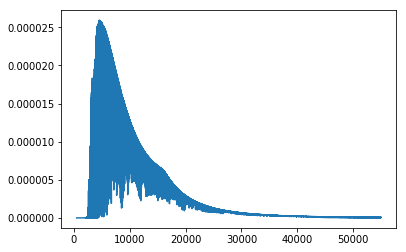

In [29]:
flux_of_target = flux_of_target * (u.erg / u.s / u.cm ** 2 / u.cm) 
waveset_of_target = waveset_of_target * u.Angstrom

plt.plot(waveset_of_target, flux_of_target)

<a id="observer"></a>
## 3. Set the location of the observer

Create an </tt>astroplan<tt> Observer object via the <tt>at_site</tt> class method to set the location of the observing site:

In [30]:
from astroplan import Observer

observer = Observer.at_site('apo')

# Getting an exposure time

If you want to get an idea of how long each exposure should be to achieve a desired signal to noise ratio, you can use <tt>astroplan</tt>'s <tt>exptime_from_ccd_snr</tt> function.

<a id="telescope"></a>
## 4. Set up the telescope model

Create a <tt>Telescope</tt> object, which models the telescope you wish to use, and input:
<ul>
    <li>the diameter of the telescope aperture (we use the 3.5m telescope at APO)</li>
    <li>a model of your bandpass (we use <tt>synphot</tt> to generate a bandpass downloaded from SVO)</li>
    <li> the gain of the instrument, which is usually found on the observatory's website</li>
</ul>
You can also give it a CCD response function, either from your own model or the default model given by <tt>astroplan.telescope</tt> as we've done here.

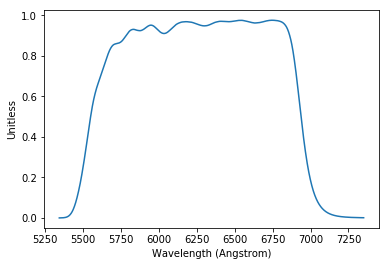

In [31]:
from synphot.spectrum import SpectralElement
from astropy.utils.data import download_file
from astroplan import Telescope

diameter = 3.5 * u.m
gain = 1.9 * (u.ct / u.adu)

# model the bandpass:
svo_link = ('http://svo2.cab.inta-csic.es/' +
           'theory/fps3/fps.php?ID=')
filt_path = download_file(svo_link + 'SLOAN/SDSS.rprime_filter')
bandpass = SpectralElement.from_file(filt_path)

bandpass.plot()

In [32]:
telescope = Telescope(diameter, bandpass, gain, ccd_response='default')

Text(0.5, 0, 'nm')

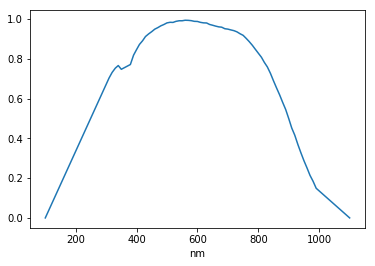

In [33]:
ccd_response_wls, ccd_response = telescope.ccd_response
plt.plot(ccd_response_wls, ccd_response)
plt.xlabel(ccd_response_wls.unit)

<a id="exptime"></a>
## 5. Calculate the exposure time

Then specify the signal to noise ratio you wish to reach and call <tt>astroplan</tt>'s <tt>exptime_from_ccd_snr</tt> function:

In [34]:
from astroplan import exptime_from_ccd_snr

snr = 100
exptime_from_ccd_snr(snr, waveset_of_target, flux_of_target, observer, telescope)

<Quantity 0.00225564 s>

<a id="skymodel"></a>
## 6. (optional) Add an atmospheric transmission model

Say you want to add the effect of the atmosphere to make the exposure time prediction more realistic. You can pass your own sky model as an array into your <tt>observer</tt> object, or you can query from the SKYCALC Sky Model Calculator with <tt>astroplan</tt>'s <tt>skycalc.skymodel()</tt>:

In [35]:
from astroplan import skymodel

skymodel_1pt5airmass = skymodel(airmass=1.5)

<tt>skymodel</tt> has many different sky parameters that can be set, including the precipitable water vapor, whether or not to include the moon, and more. For options and defaults, see the documentation on <tt>astroplan.skycalc.skymodel</tt>

The <tt>skymodel</tt> attribute must then be set for the <tt>observer</tt> object (alternatively, you could have passed it in as an optional argument when initiating the observer object):

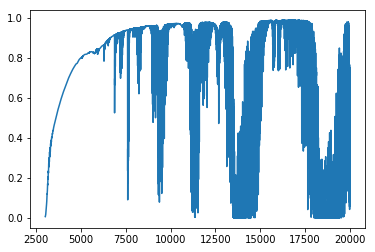

In [36]:
observer.skymodel = skymodel_1pt5airmass
# alternatively: >>> observer = Observer.at_site('apo', skymodel=skymodel_1pt5airmass)
skymodel_waveset, skymodel_flux = observer.skymodel
plt.plot(skymodel_waveset, skymodel_flux)

In [24]:
exptime_from_ccd_snr(snr, waveset_of_target, flux_of_target, observer, telescope)

<Quantity 0.00260731 s>